Reference Graphs:



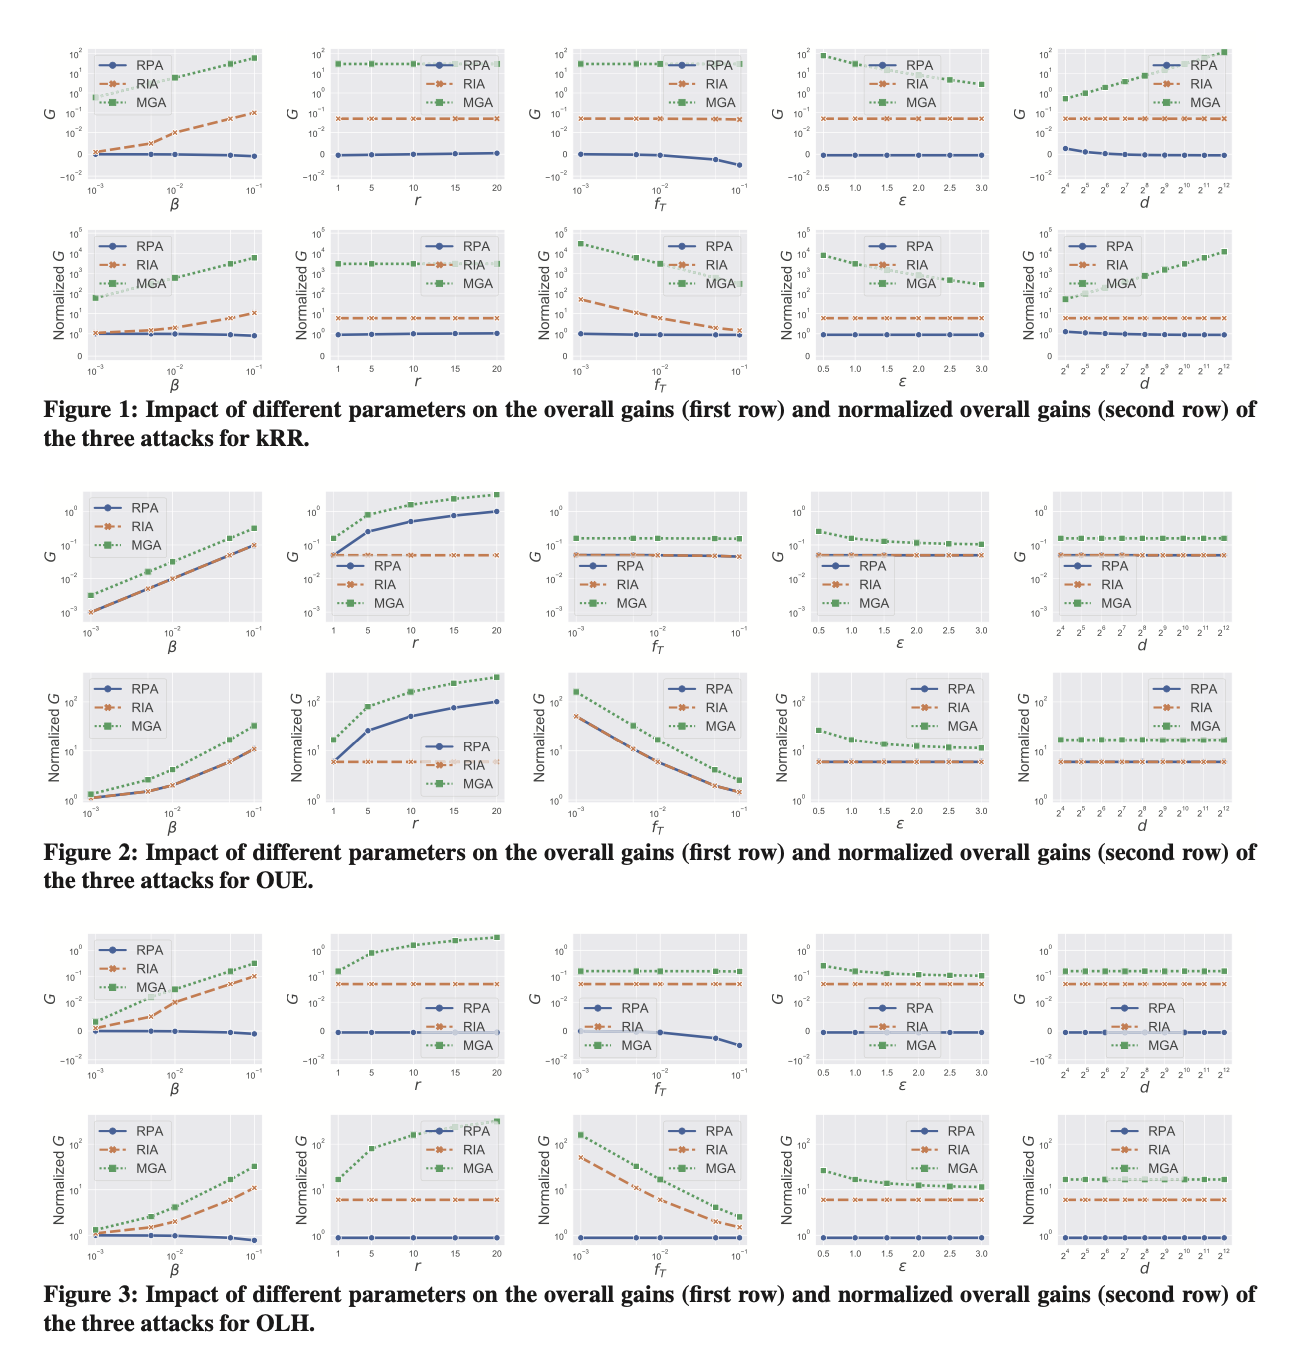



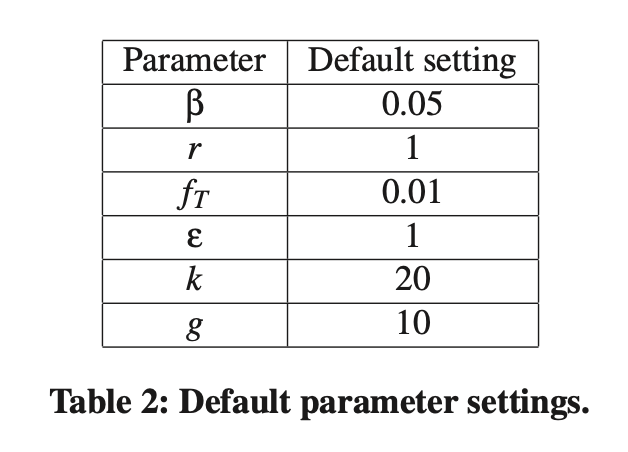

Plotting Code:

In [ ]:
# parameters from table 2 in the paper
DEFAULTS = {
    'beta': 0.05,
    'r': 1,
    'fT': 0.01,
    'epsilon': 1,
    'd': 1024
}

In [ ]:
# imports & settings

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'sans-serif', 'font.size': 10, 'axes.linewidth': 0.8,
    'xtick.major.width': 0.8, 'ytick.major.width': 0.8
})

COLORS =  {'RPA': '#9467bd', 'RIA': '#e74c3c', 'MGA': '#17becf'}
MARKERS = {'RPA': 'o', 'RIA': 'x', 'MGA': 's'}
LINES =   {'RPA': '-', 'RIA': '--', 'MGA': ':'}
SIZES =   {'RPA': 5, 'RIA': 7, 'MGA': 5}

RANGES = {
    'beta': np.logspace(-3, -1, 20),
    'r': np.array([1, 5, 10, 15, 20]),
    'fT': np.logspace(-3, -1, 20),
    'epsilon': np.linspace(0.5, 3.0, 20),
    'd': 2**np.arange(4, 13)
}

# later used for plotting MGA
MGA_VALUES = {
    'kRR': {'gains': {}, 'norm_gains': {}},
    'OUE': {'gains': {}, 'norm_gains': {}},
    'OLH': {'gains': {}, 'norm_gains': {}}
}


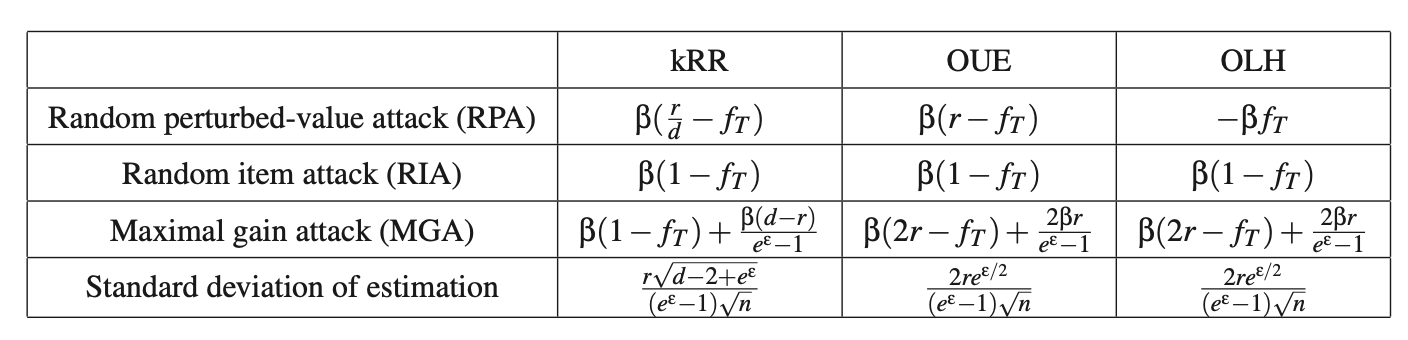

In [ ]:
# gains as calculated in the paper

def compute_gains_kRR(beta, r, fT, epsilon, d):
    e_eps = np.exp(epsilon)
    return (
        beta * (r/d - fT),                                # RPA
        beta * (1 - fT),                                  # RIA
        beta * (1 - fT) + beta * (d - r) / (e_eps - 1)    # MGA
    )

def compute_gains_OUE(beta, r, fT, epsilon, d):
    return (
        beta * (r - fT),
        beta * (1 - fT),
        beta * (2*r - fT) + 2*beta*r / (np.exp(epsilon) - 1)
    )

def compute_gains_OLH(beta, r, fT, epsilon, d):
    e_eps = np.exp(epsilon)
    return (
        -beta * fT,
        beta * (1 - fT),
        beta * (2*r - fT) + 2*beta*r / (e_eps - 1)
    )

def normalized_gain(G, fT):
    return (G + fT) / fT

In [ ]:
# plotting related

# generalized function to make code concise
def compute_all_gains(protocol_name, protocol_func, param_name, param_range, use_varying_fT=False):
    gains = {'RPA': [], 'RIA': [], 'MGA': []}
    for param_val in param_range:
        params = DEFAULTS.copy()
        params[param_name] = param_val
        G_RPA, G_RIA, G_MGA = protocol_func(**params)
        gains['RPA'].append(G_RPA)
        gains['RIA'].append(G_RIA)
        gains['MGA'].append(G_MGA)

    for key in gains:
        gains[key] = np.array(gains[key])

    fT_for_norm = param_range if use_varying_fT else DEFAULTS['fT']
    norm_gains = {key: normalized_gain(gains[key], fT_for_norm) for key in gains}

    MGA_VALUES[protocol_name]['gains'][param_name] = gains['MGA'].copy()
    MGA_VALUES[protocol_name]['norm_gains'][param_name] = norm_gains['MGA'].copy()

    return gains, norm_gains

def plot_row(ax, x_data, gains, xlabel, xscale, row_type, use_xticks=None, markevery=1):
    for attack in ['RPA', 'RIA', 'MGA']:
        ax.plot(
            x_data, gains[attack],
            color=COLORS[attack], marker=MARKERS[attack], linestyle=LINES[attack],
            label=attack, markersize=SIZES[attack], linewidth=1.5,
            markerfacecolor=COLORS[attack] if attack != 'RIA' else None,
            markeredgewidth=2 if attack == 'RIA' else 1,
            markevery=markevery
        )

    ax.set_xscale(xscale)
    ax.set_xlabel(xlabel, fontsize=12, fontstyle='italic')
    ax.legend(loc='best', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.grid(True, alpha=0.3, which='major', linestyle='-', linewidth=0.5)

    if row_type == 'top':
        ax.set_yscale('symlog', linthresh=1e-2)
        ax.set_ylim([-1e-2, 1e2])
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_yticks([1e2, 1e1, 1e0, 1e-1, 1e-2, 0, -1e-2])
    else:
        ax.set_yscale('symlog', linthresh=1)
        ax.set_ylim([0, 1e5])
        ax.set_yticks([0, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5])

    if use_xticks is not None:
        ax.set_xticks(use_xticks)
        ax.set_xticklabels([f'$2^{{{int(np.log2(t))}}}$' for t in use_xticks])

def plot_figure_OUE(ax, x_data, gains, xlabel, xscale, row_type, use_xticks=None, markevery=1):
    for attack in ['RPA', 'RIA', 'MGA']:
        ax.plot(
            x_data, gains[attack],
            color=COLORS[attack], marker=MARKERS[attack], linestyle=LINES[attack],
            label=attack, markersize=SIZES[attack], linewidth=1.5,
            markerfacecolor=COLORS[attack] if attack != 'RIA' else None,
            markeredgewidth=2 if attack == 'RIA' else 1
        )

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_xscale(xscale)
    ax.set_yscale('log')

    if row_type == 'top':
        ax.set_ylim(1e-3, 1e1)
    else:
        ax.set_ylim(1e0, 1e3)

    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

    if use_xticks is not None:
        ax.set_xticks(use_xticks)
        ax.set_xticklabels([f'$2^{{{int(np.log2(d))}}}$' for d in use_xticks], fontsize=8)

def create_figure(protocol_func, protocol_name, use_log=False):
    fig, axes = plt.subplots(2, 5, figsize=(17, 6.5))

    param_configs = [
        ('beta', r'$\beta$', 'log', None, 2),
        ('r', r'$r$', 'linear', [1, 5, 10, 15, 20], 1),
        ('fT', r'$f_T$', 'log', None, 2),
        ('epsilon', r'$\varepsilon$', 'linear', [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 2),
        ('d', r'$d$', 'log', RANGES['d'], 1)
    ]

    for col, (param_name, xlabel, xscale, xticks, markevery) in enumerate(param_configs):
        use_varying_fT = (param_name == 'fT')

        gains, norm_gains = compute_all_gains(
            protocol_name, protocol_func, param_name, RANGES[param_name], use_varying_fT
        )

        if use_log:
            plot_figure_OUE(axes[0, col], RANGES[param_name], gains, xlabel, xscale, 'top', xticks, markevery)
            axes[0, col].set_ylabel('G', fontsize=12)
        else:
            plot_row(axes[0, col], RANGES[param_name], gains, xlabel, xscale, 'top', xticks, markevery)
            axes[0, col].set_ylabel(r'$G$', fontsize=12, fontstyle='italic')

        if use_log:
            plot_figure_OUE(axes[1, col], RANGES[param_name], norm_gains, xlabel, xscale, 'bottom', xticks, markevery)
            axes[1, col].set_ylabel('Normalized G', fontsize=11)
        else:
            plot_row(axes[1, col], RANGES[param_name], norm_gains, xlabel, xscale, 'bottom', xticks, markevery)
            axes[1, col].set_ylabel('Normalized G', fontsize=11)

        if param_name == 'r':
            axes[0, col].set_xlim([0, 21])
            axes[1, col].set_xlim([0, 21])
        elif param_name == 'epsilon':
            axes[0, col].set_xlim([0.4, 3.1])
            axes[1, col].set_xlim([0.4, 3.1])

    plt.tight_layout(rect=[0, 0.05, 1, 1])

    return fig

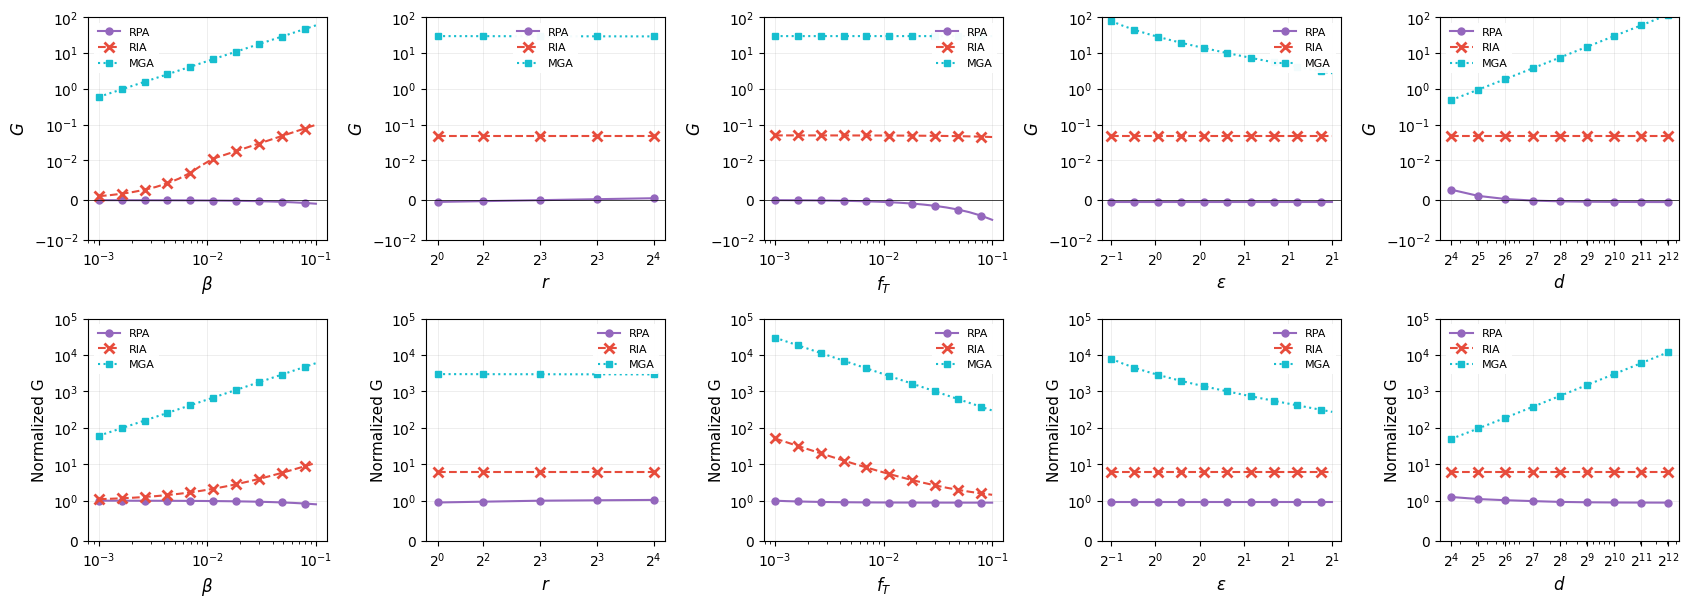

In [ ]:
# kRR

fig1 = create_figure(compute_gains_kRR, 'kRR', use_log=False)
fig1.savefig('kRR.png')
plt.show()

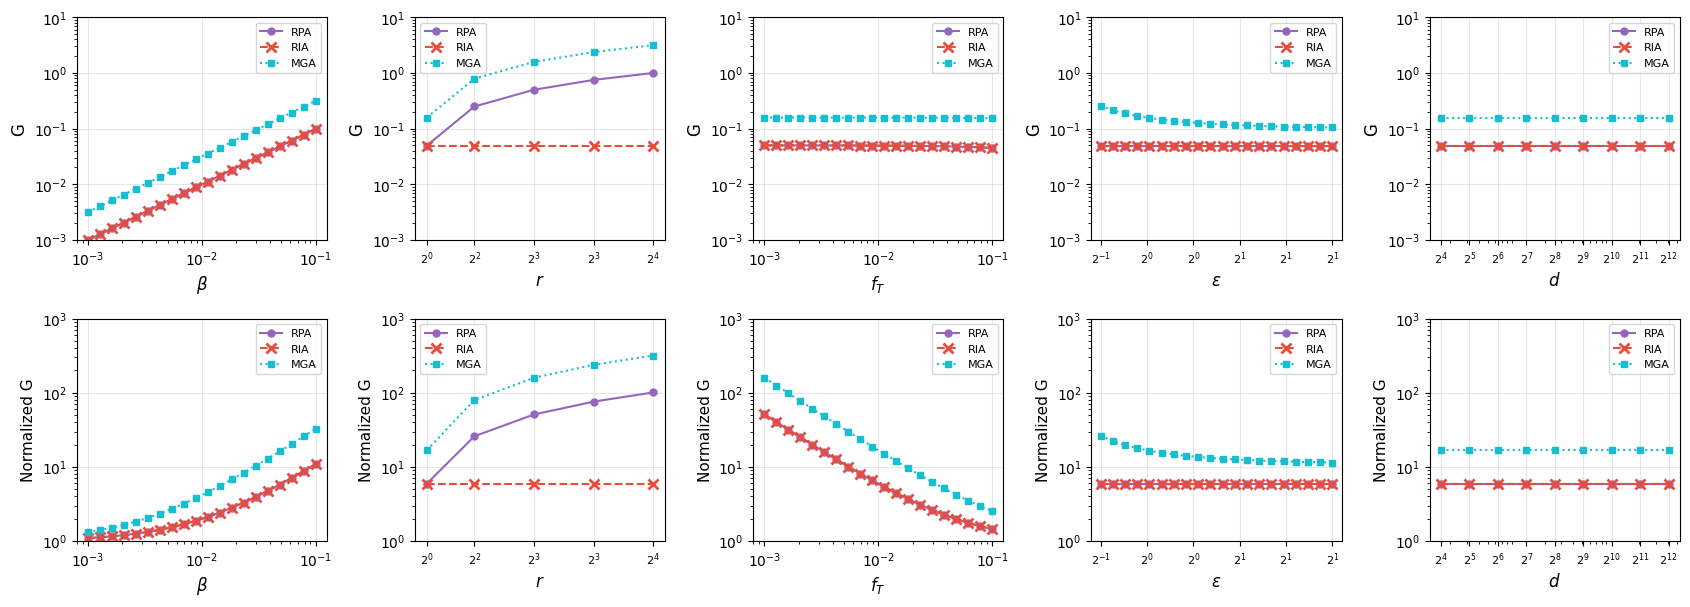

In [ ]:
# OUE

fig2 = create_figure(compute_gains_OUE, 'OUE', use_log=True)
fig2.savefig('oue.png')
plt.show()

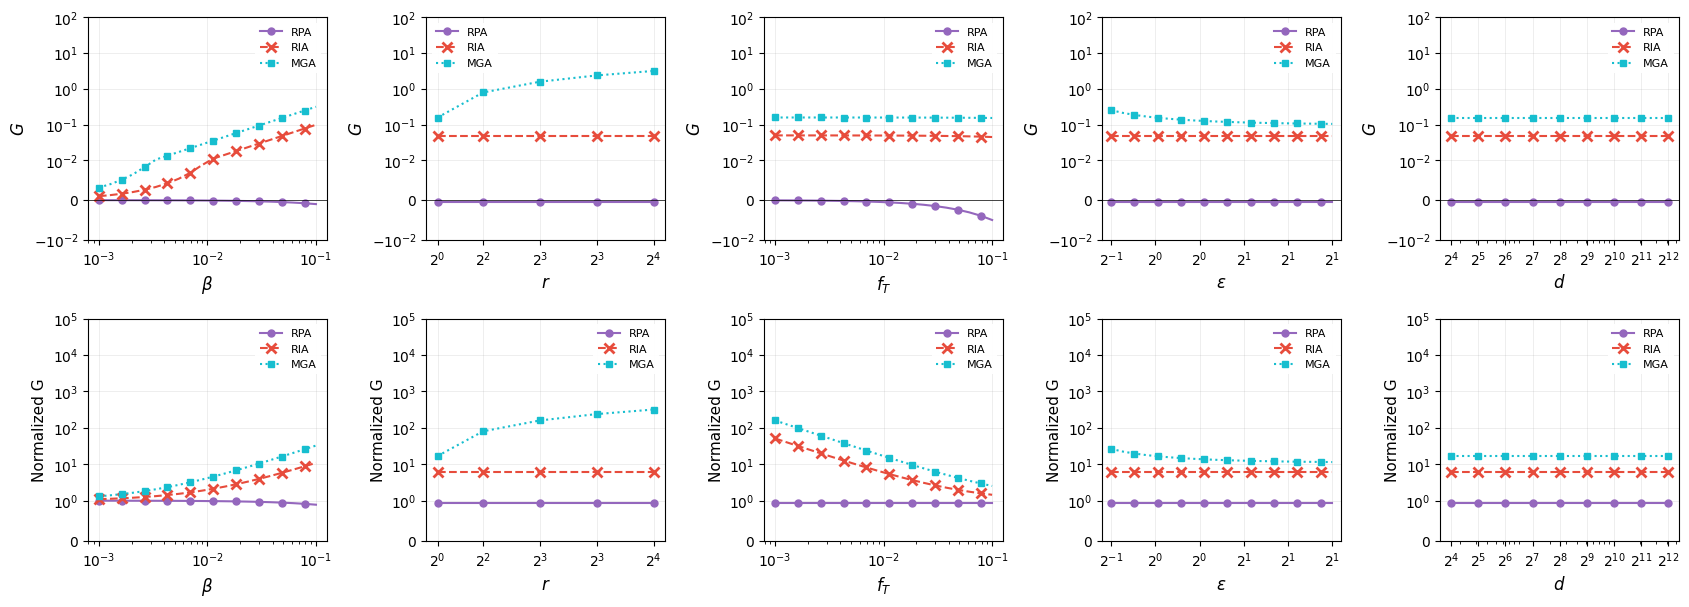

In [ ]:
# OLH

fig3 = create_figure(compute_gains_OLH, 'OLH', use_log=False)
fig3.savefig('olh.png')
plt.show()

In [ ]:
# MGA comparison plot


COLORS =  {'kRR': '#2ecc71', 'OUE & OLH': '#3498db'}
MARKERS = {'kRR': 'o', 'OUE & OLH': 's'}
LINES =   {'kRR': '-', 'OUE & OLH': '--'}
SIZES =   {'kRR': 5, 'OUE & OLH': 5}

def plot_mga_comparison(ax, x_data, mga_gains, xlabel, xscale, row_type, use_xticks=None, markevery=1):
    for protocol in ['kRR', 'OUE & OLH']:
        ax.plot(
            x_data, mga_gains[protocol],
            color=COLORS[protocol], marker=MARKERS[protocol], linestyle=LINES[protocol],
            label=protocol, markersize=SIZES[protocol], linewidth=1.5,
            markerfacecolor=COLORS[protocol] if protocol != 'OUE & OLH' else None,
            markeredgewidth=2 if protocol == 'OUE & OLH' else 1,
            markevery=markevery
        )

    ax.set_xscale(xscale)
    ax.set_xlabel(xlabel, fontsize=12, fontstyle='italic')
    ax.legend(loc='best', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.grid(True, alpha=0.3, which='major', linestyle='-', linewidth=0.5)

    if row_type == 'top':
        ax.set_yscale('symlog', linthresh=1e-2)
        ax.set_ylim([-1e-2, 1e2])
        ax.axhline(y=0, color='black', linewidth=0.5)
        ax.set_yticks([1e2, 1e1, 1e0, 1e-1, 1e-2, 0, -1e-2])
    else:
        ax.set_yscale('symlog', linthresh=1)
        ax.set_ylim([0, 1e5])
        ax.set_yticks([0, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5])

    if use_xticks is not None:
        ax.set_xticks(use_xticks)
        ax.set_xticklabels([f'$2^{{{int(np.log2(t))}}}$' for t in use_xticks])

def create_MGA_plot():
    fig, axes = plt.subplots(2, 5, figsize=(17, 6.5))

    param_configs = [
        ('beta', r'$\beta$', 'log', None, 2),
        ('r', r'$r$', 'linear', [1, 5, 10, 15, 20], 1),
        ('fT', r'$f_T$', 'log', None, 2),
        ('epsilon', r'$\varepsilon$', 'linear', [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 2),
        ('d', r'$d$', 'log', RANGES['d'], 1)
    ]

    for col, (param_name, xlabel, xscale, xticks, markevery) in enumerate(param_configs):
        mga_gains = {
            'kRR': MGA_VALUES['kRR']['gains'][param_name],
            'OUE & OLH': MGA_VALUES['OUE']['gains'][param_name]      # same values for OUE & OLH
        }

        mga_norm_gains = {
            'kRR': MGA_VALUES['kRR']['norm_gains'][param_name],
            'OUE & OLH': MGA_VALUES['OUE']['norm_gains'][param_name] # same values for OUE & OLH
        }

        plot_mga_comparison(axes[0, col], RANGES[param_name], mga_gains, xlabel, xscale, 'top', xticks, markevery)
        axes[0, col].set_ylabel(r'$G_{MGA}$', fontsize=12, fontstyle='italic')

        plot_mga_comparison(axes[1, col], RANGES[param_name], mga_norm_gains, xlabel, xscale, 'bottom', xticks, markevery)
        axes[1, col].set_ylabel('Normalized $G_{MGA}$', fontsize=11)

        if param_name == 'r':
            axes[0, col].set_xlim([0, 21])
            axes[1, col].set_xlim([0, 21])
        elif param_name == 'epsilon':
            axes[0, col].set_xlim([0.4, 3.1])
            axes[1, col].set_xlim([0.4, 3.1])

    plt.tight_layout(rect=[0, 0.05, 1, 1])

    return fig


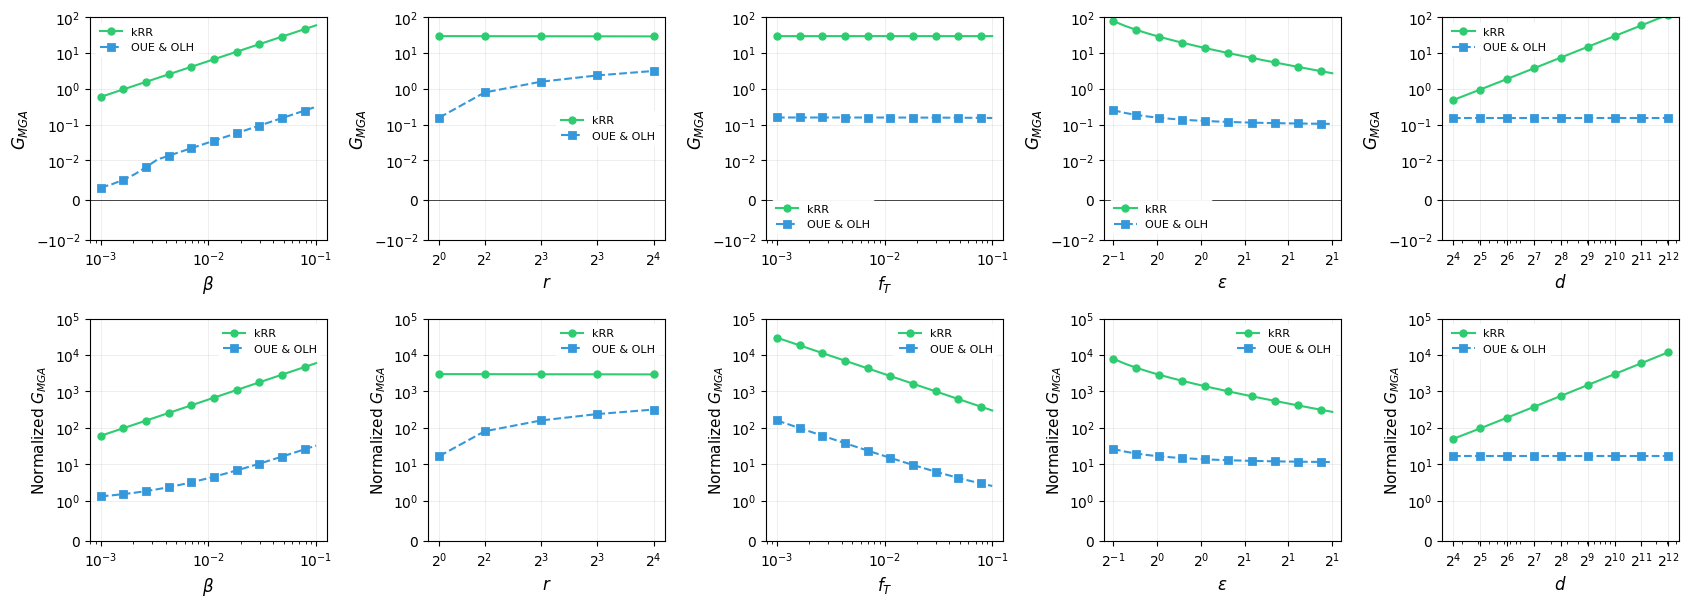

In [ ]:
# MGA Comparison

fig4 = create_MGA_plot()
fig4.savefig('mga_comparison.png')
plt.show()

In [ ]:
MGA_VALUES.keys()

dict_keys(['kRR', 'OUE', 'OLH'])

In [ ]:
MGA_VALUES['kRR'].keys()

dict_keys(['gains', 'norm_gains'])

In [ ]:
MGA_VALUES['kRR']['gains']

{'beta': array([ 0.59635217,  0.75991665,  0.96834278,  1.23393499,  1.57237249,
         2.00363493,  2.55318187,  3.25345579,  4.14579733,  5.28288584,
         6.73184928,  8.57822714, 10.93102027, 13.92912569, 17.74953644,
        22.6177903 , 28.82128441, 36.72624178, 46.79933121, 59.63521711]),
 'r': array([29.81760856, 29.70121321, 29.55571904, 29.41022486, 29.26473068]),
 'fT': array([29.81805856, 29.81804484, 29.81802737, 29.8180051 , 29.81797672,
        29.81794057, 29.81789449, 29.81783578, 29.81776096, 29.81766562,
        29.81754414, 29.81738933, 29.81719207, 29.8169407 , 29.81662038,
        29.81621221, 29.81569209, 29.81502932, 29.81418476, 29.81310856]),
 'epsilon': array([78.89692232, 58.13637591, 44.72045409, 35.40602766, 28.61271013,
        23.47814672, 19.4917003 , 16.33164699, 13.78515467, 11.70577215,
         9.98940137,  8.56001036,  7.36077102,  6.34836128,  5.48918685,
         4.75680781,  4.13014386,  3.59219618,  3.12911996,  2.72953988]),
 'd': array([